# **Learn Facial Landmark Detection using Dlib Library**

1. Apply Facial Landmark Detection

👀 Facial Landmark are essential attributes of a human face that allow us to distinguish between different faces. Facial landmarks are used to identify and represent key parts of a human face, such as nose, eyebrow, mouth, or eye corners.

Src: Datagen.tech

Source  For Facial Landmark (DLib) : http://dlib.net/face_landmark_detection_ex.cpp.html

In [1]:
# Setup and import Libraries
import cv2
import dlib
import numpy as np
from matplotlib import pyplot as plt

In [2]:
  # Download and unzip our images and Facial landmark model
!wget https://moderncomputervision.s3.eu-west-2.amazonaws.com/images.zip
!wget https://moderncomputervision.s3.eu-west-2.amazonaws.com/shape_predictor_68_face_landmarks.zip

# Unzip downloaded content
!unzip -qq images.zip
!unzip -qq shape_predictor_68_face_landmarks.zip

--2023-05-01 07:38:55--  https://moderncomputervision.s3.eu-west-2.amazonaws.com/images.zip
Resolving moderncomputervision.s3.eu-west-2.amazonaws.com (moderncomputervision.s3.eu-west-2.amazonaws.com)... 3.5.246.114
Connecting to moderncomputervision.s3.eu-west-2.amazonaws.com (moderncomputervision.s3.eu-west-2.amazonaws.com)|3.5.246.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29586716 (28M) [application/zip]
Saving to: ‘images.zip’

images.zip          100%[===================>]  28.22M  6.73MB/s    in 4.2s    

2023-05-01 07:39:00 (6.73 MB/s) - ‘images.zip’ saved [29586716/29586716]

--2023-05-01 07:39:00--  https://moderncomputervision.s3.eu-west-2.amazonaws.com/shape_predictor_68_face_landmarks.zip
Resolving moderncomputervision.s3.eu-west-2.amazonaws.com (moderncomputervision.s3.eu-west-2.amazonaws.com)... 52.95.148.2
Connecting to moderncomputervision.s3.eu-west-2.amazonaws.com (moderncomputervision.s3.eu-west-2.amazonaws.com)|52.95.148.2|:443... 

In [3]:
# Define our imshow function 
def imshow(title = "Image", image = None, size = 10):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

## **Facial Landmark Detection**

In [7]:
PREDICTOR_PATH = "shape_predictor_68_face_landmarks.dat"
predictor = dlib.shape_predictor(PREDICTOR_PATH)
detector = dlib.get_frontal_face_detector()

In [8]:
# Raise Exception
class TooManyFaces(Exception):
    pass

class NoFaces(Exception):
    pass

In [9]:
def get_landmarks(im):
    rects = detector(im, 1)

    if len(rects) > 1:
        raise TooManyFaces
    if len(rects) == 0:
        raise NoFaces

    return np.matrix([[p.x, p.y] for p in predictor(im, rects[0]).parts()])

In [10]:
def annotate_landmarks(img, landmarks):
    img = img.copy()
    for idx, point in enumerate(landmarks):
        pos = (point[0, 0], point[0, 1])
        cv2.putText(img, str(idx), pos,
                    fontFace=cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,
                    fontScale=0.4,
                    
                    color=(0, 0, 255))
        cv2.circle(img, pos, 3, color=(0, 255, 255))
    return img

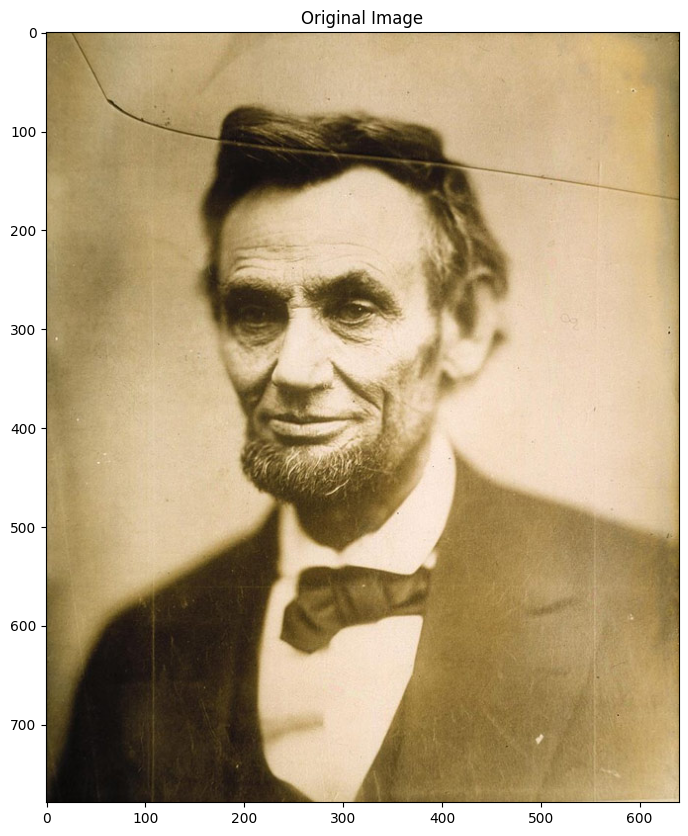

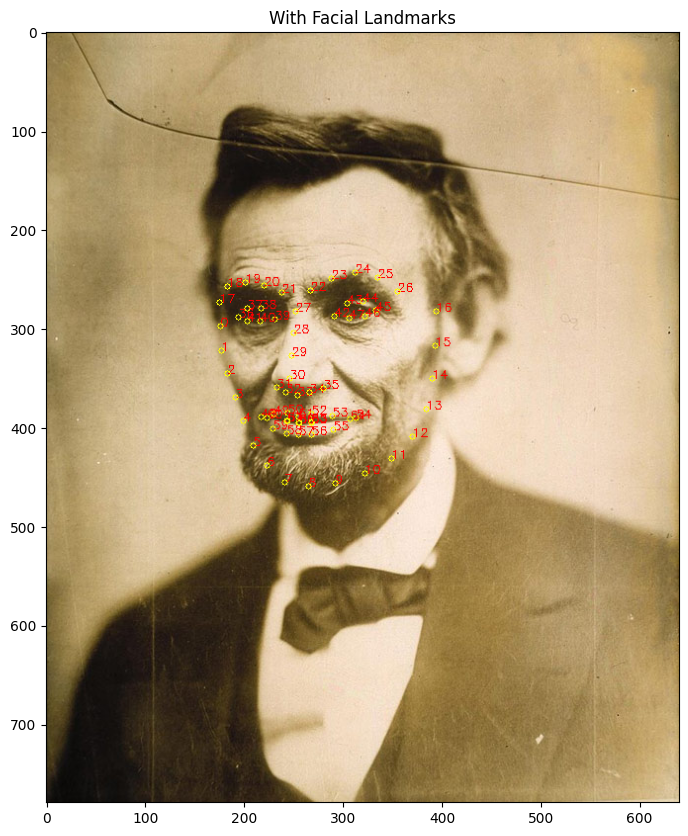

In [11]:
image = cv2.imread('images/abraham.jpg')
imshow('Original Image', image)
landmarks = get_landmarks(image)
image_with_landmarks = annotate_landmarks(image, landmarks)
imshow('With Facial Landmarks', image_with_landmarks)